# Document (QnA) Matching Data Science Process

## Part 5: 
Calibrated Support Vector Machine Classifier

### Overview

This notebook is Part 1 of 5, in a series providing a step-by-step description of how to create discriminative training methods to match the correct answer to a given question. Using Python packages and custom code examples, we have implemented the basic framework that combines key phrase learning and latent topic modeling as described in the paper entitled ["Modeling Multiword Phrases with Constrained Phrases Tree for Improved Topic Modeling of Conversational Speech"](http://people.csail.mit.edu/hazen/publications/Hazen-SLT-2012.pdf) which was originally presented in the 2012 IEEE Workshop on Spoken Language Technology.

Although the paper examines the use of the technology for analyzing human-to-human conversations, the techniques are quite general and can be applied to a wide range of natural language data including news stories, legal documents, research publications, social media forum discussions, customer feedback forms, product reviews, and many more.

Also, we implement a Naive Bayes Classifier as described in the paper entitled ["MCE Training Techniques for Topic Identification of Spoken Audio Documents"](http://ieeexplore.ieee.org/abstract/document/5742980/). 

Part 5 of the series shows the implementation of One-versus-rest SVM Classifier. For the features used to train the Classifier, we use the Naive Bayes scores obtained from Part 4. 

Note: This notebook series are built under Python 3.5 and NLTK 3.2.2.

## Import required Python modules

In [36]:
import pandas as pd
import math
import gc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from IPython.display import display

%matplotlib inline

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

## Read trainQ and testQ into DataFrames

In [4]:
trainQ_url = 'https://mezsa.blob.core.windows.net/stackoverflow/trainQwithTokens.tsv'
testQ_url = 'https://mezsa.blob.core.windows.net/stackoverflow/testQwithTokens.tsv'

trainQ = pd.read_csv(trainQ_url, sep='\t', index_col='Id', encoding='latin1')
testQ = pd.read_csv(testQ_url, sep='\t', index_col='Id', encoding='latin1')

## Create Tokens to IDs Hash

For each token in the entire vocabulary, we assign it an unique ID.

In [5]:
# get Token to ID mapping: {Token: tokenId}
def tokens_to_ids(tokens, featureHash):
    token2IdHash = {}
    for i in range(len(tokens)):
        tokenList = tokens.iloc[i].split(',')
        if featureHash is None:
            for t in tokenList:
                if t not in token2IdHash.keys():
                    token2IdHash[t] = len(token2IdHash)
        else:
            for t in tokenList:
                if t not in token2IdHash.keys() and t in list(featureHash.keys()):
                    token2IdHash[t] = len(token2IdHash)
            
    return token2IdHash

In [6]:
token2IdHashInit = tokens_to_ids(trainQ['Tokens'], None)

In [7]:
print("Total number of unique tokens in the TrainQ: " + str(len(token2IdHashInit)))

Total number of unique tokens in the TrainQ: 4977


## Create Count Matrix for Each Token in Each Answer

In [9]:
def count_matrix(frame, token2IdHash, uniqueAnswerId):
    # create am empty matrix with the shape of:
    # num_row = num of unique tokens
    # num_column = num of unique answerIds (N_wA) or num of questions in testQ (tfMatrix)
    # rowIdx = token2IdHash.values()
    # colIdx = index of uniqueAnswerId (N_wA) or index of questions in testQ (tfMatrix)
    num_row = len(token2IdHash)
    if uniqueAnswerId is not None:  # get N_wA
        num_column = len(uniqueAnswerId)
    else:
        num_column = len(frame)
    countMatrix = np.empty(shape=(num_row, num_column))

    # loop through each question in the frame to fill in the countMatrix with corresponding counts
    for i in range(len(frame)):
        tokens = frame['Tokens'].iloc[i].split(',')
        if uniqueAnswerId is not None:   # get N_wA
            answerId = frame['AnswerId'].iloc[i]
            colIdx = uniqueAnswerId.index(answerId)
        else:
            colIdx = i
            
        for t in tokens:
            if t in token2IdHash.keys():
                rowIdx = token2IdHash[t]
                countMatrix[rowIdx, colIdx] += 1

    return countMatrix

In [10]:
# get unique answerId in ascending order
uniqueAnswerId = list(np.unique(trainQ['AnswerId']))
# calculate the count matrix of all training questions.
N_wAInit = count_matrix(trainQ, token2IdHashInit, uniqueAnswerId)

## Feature Selection Based on Posteriori Probability P(A|w) 

<img src="https://raw.githubusercontent.com/Azure/Document_Matching/master/pic/feature_selection.PNG?token=APoO9ioyiKq8Sx0dxZ5onqIzyy6ywUmEks5YnH6cwA%3D%3D">

In [11]:
# calculate P(A): [P_A1, P_A2, ...]
def prior_probability_answer(answerIds, uniqueAnswerId): 
    P_A = []
    # convert a pandas series to a list
    answerIds = list(answerIds)
    
    for id in uniqueAnswerId:
        P_A.append(answerIds.count(id)/len(answerIds))
    return np.array(P_A)

In [12]:
P_A = prior_probability_answer(trainQ['AnswerId'], uniqueAnswerId)

In [13]:
# calculate P(A|w)
def posteriori_prob(N_wAInit, P_A, uniqueAnswerId):
    # N_A is the total number of answers
    N_A = len(uniqueAnswerId)
    # N_w is the total number of times w appears over all documents 
    # rowSum of count matrix (N_wAInit)
    N_wInit = np.sum(N_wAInit, axis = 1)
    # P(A|w) = (N_w|A + N_A * P(A))/(N_w + N_A)
    N = N_wAInit + N_A * P_A
    D = N_wInit + N_A
    P_Aw = np.divide(N.T, D).T    
    
    return P_Aw

In [14]:
P_Aw = posteriori_prob(N_wAInit, P_A, uniqueAnswerId)

In [15]:
# select the top N tokens w which maximize P(A|w) for each A.
# get FeatureHash: {token: 1}
def feature_selection(P_Aw, token2IdHashInit, topN):
    featureHash = {}
    # for each answer A, sort tokens w by P(A|w)
    sortedIdxMatrix = np.argsort(P_Aw, axis=0)[::-1]
    # select top N tokens for each answer A
    topMatrix = sortedIdxMatrix[0:topN, :]
    # for each token w in topMatrix, add w to FeatureHash if it has not already been included
    topTokenIdList = np.reshape(topMatrix, topMatrix.shape[0] * topMatrix.shape[1])
    # get ID to Token mapping: {tokenId: Token}
    Id2TokenHashInit = {y:x for x, y in token2IdHashInit.items()}
    
    for tokenId in topTokenIdList:
        token = Id2TokenHashInit[tokenId]
        if token not in featureHash.keys():
            featureHash[token] = 1
    return featureHash

In [16]:
topN = 10
featureHash = feature_selection(P_Aw, token2IdHashInit, topN)

## Re-assign ID to Each Selected Token and Re-calculate Count Matrix

After selecting the top N tokens of each answer, we use the collection of selected tokens for training and re-assign an ID to each selected token. Based on the new assigned IDs, we re-calculate the Count Matrix.

In [17]:
token2IdHash = tokens_to_ids(trainQ['Tokens'], featureHash)

In [18]:
N_wA = count_matrix(trainQ, token2IdHash, uniqueAnswerId)

## Calculate P(w) on Full Collection of Training Questions (w is selected token)

<img src="https://raw.githubusercontent.com/Azure/Document_Matching/master/pic/P_w.PNG?token=APoO9vsVzM00o3cEfOPq5mUeQ_2eJK94ks5YnH6ywA%3D%3D">

In [19]:
def feature_weights(N_wA, alpha):
    # N_w is the total number of times w appears over all documents 
    # rowSum of count matrix (N_wA)
    N_w = np.sum(N_wA, axis = 1)
    # N_W is the total count of all words
    N_W = np.sum(N_wA)
    # N_V is the count of unique words in the vocabulary
    N_V = N_wA.shape[0]
    # P(w) = (N_w + 1*alpha) / (N_W +N_V*alpha)
    N2 = N_w + 1 * alpha
    D2 = N_W + alpha * N_V
    P_w = N2/D2

    return P_w

In [20]:
alpha = 0.0001
P_w = feature_weights(N_wA, alpha)

## Calculate Probability Function P(w|A) and P(w|NotA) on Training Data

<img src="https://raw.githubusercontent.com/Azure/Document_Matching/master/pic/probability_function.PNG?token=APoO9rWEZ1g_OgvWT_pleQlhT2DEFw3tks5YnIHzwA%3D%3D">

In [21]:
def word_probability_in_answer(N_wA, P_w, beta):
    # N_V is the count of unique words in the vocabulary
    N_V = N_wA.shape[0]
    # N_WA is the total count of all words in questions on answer A 
    # colSum of count matrix (N_wA)
    N_WA = np.sum(N_wA, axis=0)
    # P(w|A) = (N_w|A + beta N_V P(w))/(N_W|A + beta * N_V)
    N = (N_wA.T + beta * N_V * P_w).T
    D = N_WA + beta * N_V
    P_wA = N / D
    
    return P_wA

In [22]:
def word_probability_Notin_answer(N_wA, P_w, beta):
    # N_V is the count of unique words in the vocabulary
    N_V = N_wA.shape[0]
    # N_wNotA is the count of w over all documents but not on answer A
    # N_wNotA = N_w - N_wA
    N_w = np.sum(N_wA, axis = 1)
    N_wNotA = (N_w - N_wA.T).T
    # N_WNotA is the count of all words over all documents but not on answer A
    # N_WNotA = N_W - N_WA
    N_W = np.sum(N_wA)
    N_WA = np.sum(N_wA, axis=0)
    N_WNotA = N_W - N_WA
    # P(w|NotA) = (N_w|NotA + beta * N_V * P(w))/(N_W|NotA + beta * N_V)
    N = (N_wNotA.T + beta * N_V * P_w).T
    D = N_WNotA + beta * N_V
    P_wNotA = N / D
    
    return P_wNotA

In [23]:
beta = 0.0001
P_wA = word_probability_in_answer(N_wA, P_w, beta)
P_wNotA = word_probability_Notin_answer(N_wA, P_w, beta)

## Calculate Naive Bayes Weights

<img src="https://raw.githubusercontent.com/Azure/Document_Matching/master/pic/NB_weight.PNG?token=APoO9s-2DejCvW03RgK6zXgiXX6UT5WWks5YnjiRwA%3D%3D">

In [24]:
# given an answer set A, get the NB weights for each word w: {answerId: [(word_index1, weight1), (word_index2, weight2)]}
NBWeights = np.log(P_wA / P_wNotA)

## Calculate Normalized TF of Each Word w in Training and Test sets

Each document/question d is typically represented by a feature vector x that represents the contents of d. Because different documents can have different lengths, it can be useful to apply L1 normalmalized feature vector x. 

<img src="https://raw.githubusercontent.com/Azure/Document_Matching/master/pic/tf.PNG?token=APoO9tMyEVzqoUJYT9ALcdF3_BryHHEVks5YnIQywA%3D%3D">

In [25]:
def normalize_tf(frame, token2IdHash):
    N_wQ = count_matrix(frame, token2IdHash, None)
    N_WQ = np.sum(N_wQ, axis=0)
    
    # find the index where N_WQ is zero and remove those columns from N_wQ
    removeIdx = np.where(N_WQ == 0)[0]
    
    if len(removeIdx) > 0:
        # remove the questions where the TF is NaN
        N_wQ = np.delete(N_wQ, removeIdx, axis=1)
        N_WQ = np.delete(N_WQ, removeIdx, axis=0)
        frame = frame.drop(frame.index[removeIdx])
    
    # x_w = P_wd = count(w)/sum(count(i in V))
    x_w = N_wQ / N_WQ
    
    return x_w, frame

In [26]:
x_wTrain = normalize_tf(trainQ, token2IdHash)[0]
trainQ = normalize_tf(trainQ, token2IdHash)[1]

x_wTest = normalize_tf(testQ, token2IdHash)[0]
testQ = normalize_tf(testQ, token2IdHash)[1]

## Score Each Question in Test Set Against a Specific Answer

<img src="https://raw.githubusercontent.com/Azure/Document_Matching/master/pic/NB_scores.PNG?token=APoO9vABVheo1aZRkUYQq41utE6VRM1Yks5YnITBwA%3D%3D">

In [27]:
beta_A = 0
NBScoresTrain = -beta_A + np.dot(x_wTrain.T, NBWeights)
NBScoresTest = -beta_A + np.dot(x_wTest.T, NBWeights)

## Fit One-vs-Rest SVM using NB Scores and Calibrate SVM Scores into Probabiilty Estimates

Traditional SVM training finds a hyperplane which maximally seperates positive and negative training tokens in a vector space. In its standard form, an SVM is a two-class classifier. To create a multi-class SVM for a problem with N_A classes, a one-versus-rest SVM classifier is typically learned for each answer class a. 

Firstly, we fit a linear one-vs-rest Support Vector Classifier using _svm.LinearSVC()_ from an open-source Python package **Scikit Learn**. The features are used to train the Classifier are Naive Bayes scores obtained on the training set. Like most surpervised learning methods, SVM Classifier outputs scores s(x) that can be used to rank the questions in the test set from the most probable member to the least probable member of a class a. However, those SVM scores are not equivalent to probabilities, especially in a multi-class classification case. 

In order to map scores into probability estimates, a parametric approach proposed by John Platt for SVM scores consists in finding the parameters A and B for a sigmoid function of the form P(a|X) such that the negative log-likelihood of the data is minimized.

<img src="https://raw.githubusercontent.com/Azure/Document_Matching/master/pic/calibration.PNG?token=APoO9l6Ra5QZVJjn5tR0-jcQUq8wCdufks5YnLoXwA%3D%3D">

**Scikit Learn** has an implementation of such probability calibration. 

In [28]:
# NB Scores as training features
# AnswerIds as targets
X_train = NBScoresTrain
Y_train = np.array(trainQ['AnswerId'])
X_test = NBScoresTest

In [29]:
# first, fit a Linear SVC model 
est = svm.LinearSVC(dual=False, multi_class='ovr', max_iter=7)
# then fit a Calibrated Classifier with 3-fold cross-validation
clf = CalibratedClassifierCV(est, cv=3, method='sigmoid')
%time clf.fit(X_train, Y_train) 

Wall time: 14min 18s


CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=7,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

In [30]:
# predict probabilities on the test set
Y_test_pred = clf.predict_proba(X_test)
testQ['SVMProb'] = list(Y_test_pred)

## Rank the Predicted Probability and Calcualte Average Rank 

We use two evaluation matrices to test our model performance. For each question in the test set, we calculate a calibrated probability against each answer. Then we rank the answers based on their probabilities to calculate Average Rank and Top 10 Percentage in the Test set using the below formula:

<img src="https://raw.githubusercontent.com/Azure/Document_Matching/master/pic/evaluation.PNG?token=APoO9hyYDFxGc9FRbmIXU3VGv0wdeCaPks5YnIVtwA%3D%3D">

In [31]:
# sort the predicted probability in descending order and map them to the corresponding AnswerId in Answer set
def rank(frame, scores, uniqueAnswerId):
    frame['SortedAnswers'] = list(np.array(uniqueAnswerId)[np.argsort(-scores, axis=1)])
    
    rankList = []
    for i in range(len(frame)):
        rankList.append(np.where(frame['SortedAnswers'].iloc[i] == frame['AnswerId'].iloc[i])[0][0] + 1)
    frame['Rank'] = rankList
    
    return frame

In [32]:
testQ = rank(testQ, Y_test_pred, uniqueAnswerId)

In [33]:
print('Average of rank: ' + str(np.floor(testQ['Rank'].mean())))
print('Total number of questions in test set: ' + str(len(testQ)))
print('Total number of answers: ' + str(len(uniqueAnswerId)))
print('Total number of unique features: ' + str(len(featureHash)))
print('Percentage of questions find answers in top 10: ' + str(round(len(testQ.query('Rank <= 10'))/len(testQ), 3)))

Average of rank: 38.0
Total number of questions in test set: 3671
Total number of answers: 1275
Total number of unique features: 3184
Percentage of questions find answers in top 10: 0.612


In [35]:
# check some results.
# uncomment it to execute.
# testQ.query('Rank <= 3')

## Plots and Results

Same as Part 4, we plot the Average Rank and Top 10 Percentage against different numbers of features we use to train the model. We also experiment with different combination of hyperparameters (alpha, beta, and beta_A) and the best performance on this test set is obtained as below.

<img src="https://raw.githubusercontent.com/Azure/Document_Matching/master/pic/SVM_results.PNG?token=APoO9tM_VEMo55HNM7JE3r8NkTBV109Wks5YnIluwA%3D%3D">

Please note the script below may take a while to process, so we have provided the results directly. 

In [41]:
def plot(topNList, alpha, beta, beta_A, P_Aw, token2IdHashInit, uniqueAnswerId, trainQ, testQ):

    numFeatureList = []
    avgRankList = []
    top10List = []
    
    for topN in topNList: 
        
        print('TopN = ' + str(topN))

        featureHash = feature_selection(P_Aw, token2IdHashInit, topN)
        token2IdHash = tokens_to_ids(trainQ['Tokens'], featureHash)
        N_wA = count_matrix(trainQ, token2IdHash, uniqueAnswerId)

        P_w = feature_weights(N_wA, alpha)

        P_wA = word_probability_in_answer(N_wA, P_w, beta)
        P_wNotA = word_probability_Notin_answer(N_wA, P_w, beta)

        NBWeights = np.log(P_wA / P_wNotA)

        x_wTrain = normalize_tf(trainQ, token2IdHash)[0]
        trainQ = normalize_tf(trainQ, token2IdHash)[1]

        x_wTest = normalize_tf(testQ, token2IdHash)[0]
        testQ = normalize_tf(testQ, token2IdHash)[1]

        NBScoresTrain = -beta_A + np.dot(x_wTrain.T, NBWeights)
        NBScoresTest = -beta_A + np.dot(x_wTest.T, NBWeights)
        
        X_train = NBScoresTrain
        Y_train = np.array(trainQ['AnswerId'])
        X_test = NBScoresTest
        
        est = svm.LinearSVC(dual=False, multi_class='ovr', max_iter=7)
        # determine the number of folders in Cross-valdation
        countHash = {}
        for i in trainQ['AnswerId']:
            if i not in countHash.keys():
                countHash[i] = 1
            else:
                countHash[i] += 1
        cv = sorted(countHash.items(), key=operator.itemgetter(1))[0][1]
        clf = CalibratedClassifierCV(est, cv=cv, method='sigmoid')
        %time clf.fit(X_train, Y_train) 

        Y_test_pred = clf.predict_proba(X_test)
        testQ = rank(testQ, Y_test_pred, uniqueAnswerId)

        numFeatureList.append(len(featureHash))
        avgRankList.append(np.floor(testQ['Rank'].mean()))
        top10List.append(round(len(testQ.query('Rank <= 10'))/len(testQ) * 100, 3) )
        
        gc.collect() 
        
    gc.collect() 

    return numFeatureList, avgRankList, top10List

In [72]:
topNList = [1, 2, 3, 4, 5, 10, 20, 30, 50, 80, 100, 300, 500, 1000, len(token2IdHashInit)]
alpha = 0.0001
beta = 0.0001
beta_A = 0

In [ ]:
# Note: this process may take a few hours to complete dependes on the machine that you're running on. 
# Uncomment the script when you're ready to run.
# %time numFeatureList, avgRankList, top10List = plot(topNList, alpha, beta, beta_A, P_Aw, token2IdHashInit, uniqueAnswerId, trainQ, testQ)

In [7]:
# Results from the plot() function with different number of features.
topNList = [1, 2, 3, 4, 5, 10, 20, 30, 50, 80, 100, 300, 500, 1000, 4977]
numFeatureList = [655, 1077, 1439, 1743, 2043, 3181, 4458, 4739, 4868, 4898, 4921, 4970, 4977, 4977, 4977]
avgRankList_SVM = [69.0, 53.0, 48.0, 40.0, 39.0, 37.0, 37.0, 38.0, 38.0, 37.0, 37.0, 38.0, 38.0, 38.0, 38.0]
top10List_SVM = [52.168, 55.979, 57.532, 60.065, 59.956, 61.101, 61.373, 61.972, 62.136, 61.782, 61.782, 61.863, 61.863, 61.863, 61.863]

# Results from Naive Bayes Classifier in Part 4.
avgRankList_NB = [59.0, 45.0, 44.0, 44.0, 44.0, 46.0, 48.0, 48.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0]
top10List_NB = [58.05, 60.91, 61.673, 61.645, 61.782, 61.182, 61.618, 61.863, 61.89, 61.918, 61.999, 62.027, 62.027, 62.027, 62.027]

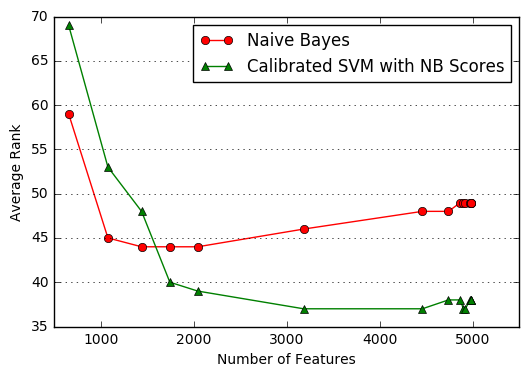

In [14]:
import matplotlib.pyplot as plt
line1, = plt.plot(numFeatureList, avgRankList_NB, linestyle='-', marker='o', color='red')
line2, = plt.plot(numFeatureList, avgRankList_SVM, linestyle='-', marker='^', color='green')
plt.xlabel('Number of Features')
plt.ylabel('Average Rank')
plt.xlim([500,5500])
plt.ylim([35,70])
ax = plt.axes()        
ax.yaxis.grid(True) # horizontal lines
ax.legend(handles=[line1, line2], labels=['Naive Bayes', 'Calibrated SVM with NB Scores'], loc=1)
plt.show()
plt.close()

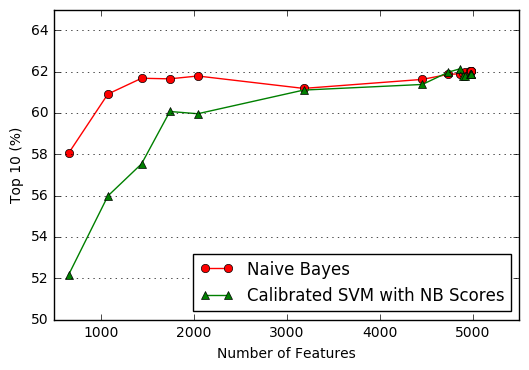

In [18]:
line1, = plt.plot(numFeatureList, top10List_NB, linestyle='-', marker='o', color='red')
line2, = plt.plot(numFeatureList, top10List_SVM, linestyle='-', marker='^', color='green')
plt.xlabel('Number of Features')
plt.ylabel('Top 10 (%)')
plt.xlim([500,5500])
plt.ylim([50,65])
ax = plt.axes()        
ax.yaxis.grid(True) # horizontal lines
ax.legend(handles=[line1, line2], labels=['Naive Bayes', 'Calibrated SVM with NB Scores'], loc=4)
plt.show()
plt.close()